In [139]:
from vectorbtpro import *
import os
import talib
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Data Ingest

In [2]:
polygon_api_key = os.getenv('POLYGON_API_KEY')
vbt.PolygonData.set_custom_settings(
    client_config=dict(
        api_key=polygon_api_key
    )
)
data = vbt.PolygonData.pull(
    ["X:BTCUSD",
    "X:ETHUSD",
    "X:SOLUSD"],
    start="2022-01-01",
    timeframe="1 day"
)

data = data.rename_symbols({'X:BTCUSD':'BTCUSD', 
                            'X:ETHUSD' : 'ETHUSD', 
                            'X:SOLUSD' : 'SOLUSD'})

data.to_hdf('priceseries.h5')

 33%|###3      | 1/3 [00:02<00:04,  2.43s/it, symbol=X:ETHUSD]

In [2]:
data = vbt.HDFData.pull('priceseries.h5')

In [3]:
open = data.get('Open')
high = data.get('High')
low = data.get('Low')
close = data.get('Close')

In [4]:
data.data['SOLUSD'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1075 entries, 2022-01-01 00:00:00+00:00 to 2024-12-10 00:00:00+00:00
Freq: D
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1075 non-null   float64
 1   High         1075 non-null   float64
 2   Low          1075 non-null   float64
 3   Close        1075 non-null   float64
 4   Volume       1075 non-null   float64
 5   Trade count  1075 non-null   int64  
 6   VWAP         1075 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 67.2 KB


## Average Directional Momentum Index (ADX)

Given date $t$ in the price-series' duration,  
$ \textbf{up\_move} = \text{high}[t] - \text{high}[t-1] $  
$ \textbf{down\_move} = \text{low}[t] - \text{low}[t-1] $

We calculate the directional momentum, the plus and minus directional indicies, and the ADX:  
(MA = moving average, ATR = average true range)  
<b>Note:</b> Different moving averages are used for the ADX calculation and the +/-DI calculation 
$$
\begin{align*}
\text{+DM} &=
\begin{cases}
\textbf{up\_move} & \text{if} \quad (\textbf{up\_move} > \text{down\_move}) \land (\textbf{up\_move} > 0) \\
0 & \text{otherwise}
\end{cases}\\\\
\text{-DM} &=
\begin{cases}
\textbf{down\_move} & \text{if} \quad (\textbf{down\_move} > \text{up\_move}) \land (\textbf{down\_move} > 0) \\
0 & \text{otherwise}
\end{cases}\\\\
\text{+DI} &= 100 \times \frac{\text{MA}_N(+DM)}{\text{ATR}_N} \\\\
\text{-DI} &= 100 \times \frac{\text{MA}_N(-DM)}{\text{ATR}_N} \\\\
\text{ADX} &= 100 \times \text{MA}_M\left(\frac{\lvert (\text{+DI}) - (\text{-DI}) \rvert}{(\text{+DI}) + (\text{-DI})}\right)
\end{align*}
$$

> The ADX does not indicate trend direction or momentum, only trend strength. It is a lagging indicator.  
> The value of the ADX is proportional to the slope of the trend.  
> -- [Wikipedia](https://en.wikipedia.org/wiki/Average_directional_movement_index)

In [51]:
N = 7
M = 10
symbol = 'SOLUSD'

In [52]:
high_shifted_1 = np.roll(high[symbol].values, 1)
high_shifted_1[0] = np.nan
plus_dm_cmp = high_shifted_1 - high[symbol].values
plus_dm = np.where(plus_dm_cmp > 0, plus_dm_cmp, 0)

In [53]:
low_shifted_1 = np.roll(low[symbol].values, 1)
low_shifted_1[0] = np.nan
minus_dm_cmp = low_shifted_1 - low[symbol].values
minus_dm = np.where(minus_dm_cmp > 0, minus_dm_cmp, 0)

In [54]:
atr = talib.ATR(high[symbol].values, low[symbol].values, close[symbol].values, N)
plus_di = 100 * (talib.EMA(plus_dm, N) / atr)
minus_di = 100 * (talib.EMA(minus_dm, N) / atr)

In [67]:
res = np.abs(plus_di - minus_di) / plus_di + minus_di
adx = talib.EMA(res, M)

In [88]:
@njit
def get_dm(high, low):
    high_shifted_1 = np.roll(high, 1)
    high_shifted_1[0] = np.nan
    plus_dm_cmp = high_shifted_1 - high
    plus_dm = np.where(plus_dm_cmp > 0, plus_dm_cmp, 0)
    
    low_shifted_1 = np.roll(low, 1)
    low_shifted_1[0] = np.nan
    minus_dm_cmp = low_shifted_1 - low
    minus_dm = np.where(minus_dm_cmp > 0, minus_dm_cmp, 0)
    return plus_dm, minus_dm
    
def get_adx_di(high, low, close, di_ma_len, adx_ma_len):
    plus_dm, minus_dm = get_dm(high, low)
    atr = talib.ATR(high, low, close, di_ma_len)
    plus_di = 100 * (talib.EMA(plus_dm, di_ma_len) / atr)
    minus_di = 100 * (talib.EMA(minus_dm, di_ma_len) / atr)
    
    res = np.abs(plus_di - minus_di) / plus_di + minus_di
    adx = talib.EMA(res, adx_ma_len)
    return adx, plus_di, minus_di

In [89]:
get_adx_di(high['SOLUSD'].values,
       low['SOLUSD'].values,
       close['SOLUSD'].values,
       14, 20)

(array([        nan,         nan,         nan, ..., 19.17019568,
        21.25877855, 22.54505495]),
 array([        nan,         nan,         nan, ..., 12.0707901 ,
        13.25176075, 26.71115704]),
 array([        nan,         nan,         nan, ..., 16.13531617,
        39.14627266, 34.47405689]))

In [90]:
ADX = vbt.IF(
    class_name = 'Average Directional Momentum Index',
    short_name = 'ADX',
    input_names = ['high', 'low', 'close'], 
    param_names = ['di_ma_len', 'adx_ma_len'],
    output_names = ['adx', 'plus_di', 'minus_di']
).with_apply_func(
    get_adx_di,
    takes_1d=True,
    di_ma_len=14,
    adx_ma_len=20
)

In [91]:
vbt.phelp(ADX.run)

Average Directional Momentum Index.run(
    high,
    low,
    close,
    di_ma_len=Default(value=14),
    adx_ma_len=Default(value=20),
    short_name='ADX',
    hide_params=None,
    hide_default=True,
    **kwargs
):
    Run `Average Directional Momentum Index` indicator.
    
    * Inputs: `high`, `low`, `close`
    * Parameters: `di_ma_len`, `adx_ma_len`
    * Outputs: `adx`, `plus_di`, `minus_di`
    
    Pass a list of parameter names as `hide_params` to hide their column levels, or True to hide all.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `Average Directional Momentum Index.run_pipeline`.


In [195]:
class ADX(Kama):
    def plot(self,
             column=None,
             high_kwargs=None,
             low_kwargs=None,
             close_kwargs=None,
             plus_di_kwargs=None,
             minus_di_kwargs=None,
             adx_kwargs=None):
        high_kwargs = high_kwargs if high_kwargs else {}
        low_kwargs = low_kwargs if low_kwargs else {}
        close_kwargs = close_kwargs if close_kwargs else {}
        
        plus_di_kwargs = plus_di_kwargs if plus_di_kwargs else {}
        minus_di_kwargs = minus_di_kwargs if minus_di_kwargs else {}
        adx_kwargs = adx_kwargs if adx_kwargs else {}

        close = self.select_col_from_obj(self.close, column).rename('Close')
        plus_di = self.select_col_from_obj(self.plus_di, column).rename('Plus DI')
        minus_di = self.select_col_from_obj(self.minus_di, column).rename('Minus DI')
        adx = self.select_col_from_obj(self.adx, column).rename('ADX')

        fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

        fig.add_trace(
            go.Scatter(x=close.index,
                       y=close.values, 
                       name="Close",
                       **close_kwargs),
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(x=adx.index,
                       y=adx.values, 
                       name="ADX",
                       **adx_kwargs),
            row=2, col=1
        )
        fig.add_trace(
            go.Scatter(x=plus_di.index,
                       y=plus_di.values, 
                       name="+DI",
                       **plus_di_kwargs),
            row=2, col=1
        )
        fig.add_trace(
            go.Scatter(x=minus_di.index,
                       y=minus_di.values, 
                       name="-DI",
                       **minus_di_kwargs),
            row=2, col=1
        )
        
        
        # Add figure title
        fig.update_layout(
            height=600, width=1000,
            title_text="ADX and DI Indicator Chart"
        )
        
        return fig
        

In [196]:
adx = ADX.run(high, low, close)

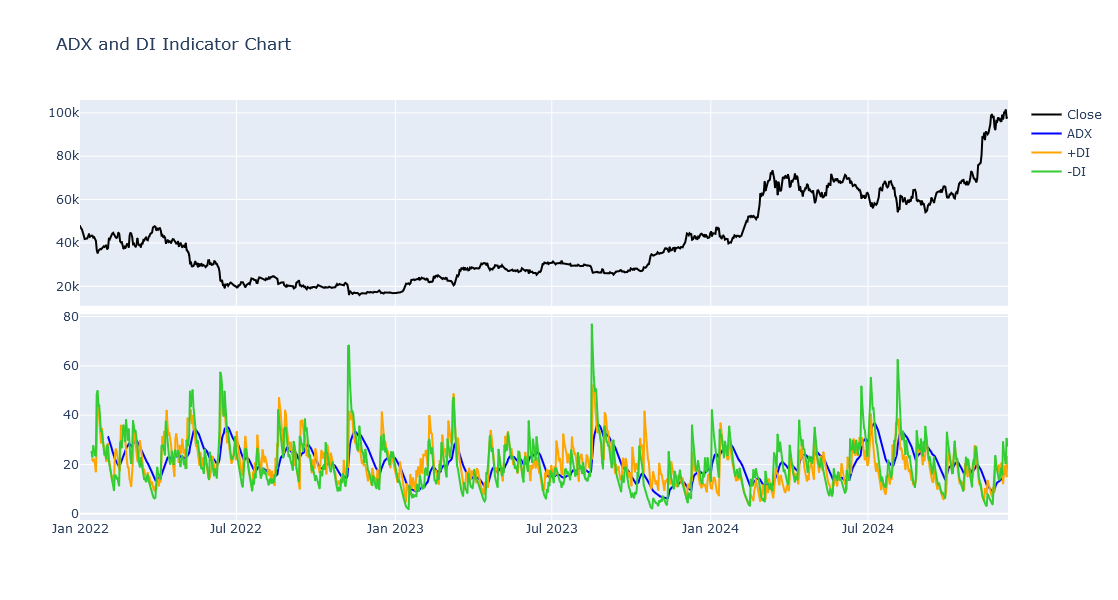

In [197]:
adx.plot(column='BTCUSD',
         close_kwargs=dict(line_color='black'),
         adx_kwargs=dict(line_color='blue'),
         plus_di_kwargs=dict(line_color='orange'),
         minus_di_kwargs=dict(line_color='limegreen')
        ).show()

## Kaufmann Adaptive Moving Average (KAMA)

$$
\begin{align*}
\text{KAMA} &= \text{KAMA}_{i-1} + \text{sc}(\text{close} - \text{KAMA}_{i-1}) \\
\text{sc} &= ((\text{ER}_i \times (\text{fastest\_sc} - \text{slowest\_sc})) + \text{slowest\_sc})^2
\end{align*}
$$  

$$
\text{fastest\_sc} = \frac{2}{\text{fast MA period}+1}
$$
$$
\text{slowest\_sc} = \frac{2}{\text{slow MA period}+1}
$$
$$
\text{ER}_i = \frac{\lvert \text{close}_i - \text{close}_{i-n} \rvert}{\sum_{j=i-n}^i \lvert \text{close}_j - \text{close}_{j-1} \rvert}
$$
$$
n = \text{number of periods}
$$




In [5]:
@njit
def get_sc(close, period, fast_ma_len, slow_ma_len):
    fastest_sc = 2 / (fast_ma_len + 1)
    slowest_sc = 2 / (slow_ma_len + 1)

    price_shifted_1 = np.roll(close,1)
    price_shifted_1[0] = np.nan
    diff_close = np.abs(close - price_shifted_1)

    conv_arr = np.ones(period,dtype=np.float64)
    denominator = np.convolve(diff_close, conv_arr, 'full')[:-(period-1)] 

    price_shifted_period = np.roll(close,period)
    price_shifted_period[0:period] = np.nan
    
    ER = np.abs(close - price_shifted_period) / denominator
    sc = (ER * (fastest_sc - slowest_sc) + slowest_sc) ** 2
    return sc

@njit
def get_kama(close, period, fast_ma_len, slow_ma_len):
    sc = get_sc(close, period, fast_ma_len, slow_ma_len)
    kama = np.full((close.shape[0]), np.nan)
    for i in range(1,close.shape[0]):  
        if not np.isnan(sc[i]):
            if np.isnan(kama[i-1]):
                kama[i-1] = close[0]
            kama[i] = kama[i-1] + (sc[i] * (close[i] - kama[i-1]))
        else:
            kama[i] = np.nan
    return kama

@njit
def get_kama_pairs(close, period, kama_st_ma_len, kama_lt_ma_len, fast_ma_len=2, slow_ma_len=30):
    kama = get_kama(close, period, fast_ma_len, slow_ma_len)
    
    st_conv_arr = np.ones(kama_st_ma_len, dtype=np.float64)
    st_conv = np.convolve(kama, st_conv_arr, 'full')[:-(kama_st_ma_len-1)] 
    kama_st_ma = st_conv / kama_st_ma_len
    
    lt_conv_arr = np.ones(kama_lt_ma_len, dtype=np.float64)
    lt_conv = np.convolve(kama, lt_conv_arr, 'full')[:-(kama_lt_ma_len-1)] 
    kama_lt_ma = lt_conv / kama_lt_ma_len

    return kama_st_ma, kama_lt_ma

In [21]:
Kama = vbt.IF(
    class_name = 'Kaufmann Adaptive Moving Average',
    short_name = 'KAMA',
    input_names = ['close'], 
    param_names = ['period', 'fast_ma_len', 'slow_ma_len', 'kama_st_ma_len', 'kama_lt_ma_len'],
    output_names = ['kama_st_ma', 'kama_lt_ma']
).with_apply_func(
    get_kama_pairs,
    takes_1d=True,
    period=2,
    fast_ma_len=2,
    slow_ma_len=30,
    kama_st_ma_len=9,
    kama_lt_ma_len=10
)

In [22]:
vbt.phelp(Kama.run)

Kaufmann Adaptive Moving Average.run(
    close,
    period=Default(value=2),
    fast_ma_len=Default(value=2),
    slow_ma_len=Default(value=30),
    kama_st_ma_len=Default(value=9),
    kama_lt_ma_len=Default(value=10),
    short_name='KAMA',
    hide_params=None,
    hide_default=True,
    **kwargs
):
    Run `Kaufmann Adaptive Moving Average` indicator.
    
    * Inputs: `close`
    * Parameters: `period`, `fast_ma_len`, `slow_ma_len`, `kama_st_ma_len`, `kama_lt_ma_len`
    * Outputs: `kama_st_ma`, `kama_lt_ma`
    
    Pass a list of parameter names as `hide_params` to hide their column levels, or True to hide all.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `Kaufmann Adaptive Moving Average.run_pipeline`.


In [23]:
class Kama(Kama):
    def plot(self,
             column=None,
             close_kwargs=None,
             kama_st_kwargs=None,
             kama_lt_kwargs=None,
             fig=None,
             **layout_kwargs
            ):
        close_kwargs = close_kwargs if close_kwargs else {}
        kama_st_kwargs = kama_st_kwargs if kama_st_kwargs else {}
        kama_lt_kwargs = kama_lt_kwargs if kama_lt_kwargs else {}

        close = self.select_col_from_obj(self.close, column).rename('Close')
        kama_st = self.select_col_from_obj(self.kama_st_ma, column).rename('ST Kama')
        kama_lt = self.select_col_from_obj(self.kama_lt_ma, column).rename('LT Kama')

        fig = close.vbt.plot(fig=fig, **close_kwargs, **layout_kwargs)
        kama_st.vbt.plot(fig=fig, **kama_st_kwargs)
        kama_lt.vbt.plot(fig=fig, **kama_lt_kwargs)

        return fig
        

In [24]:
kama = Kama.run(close)

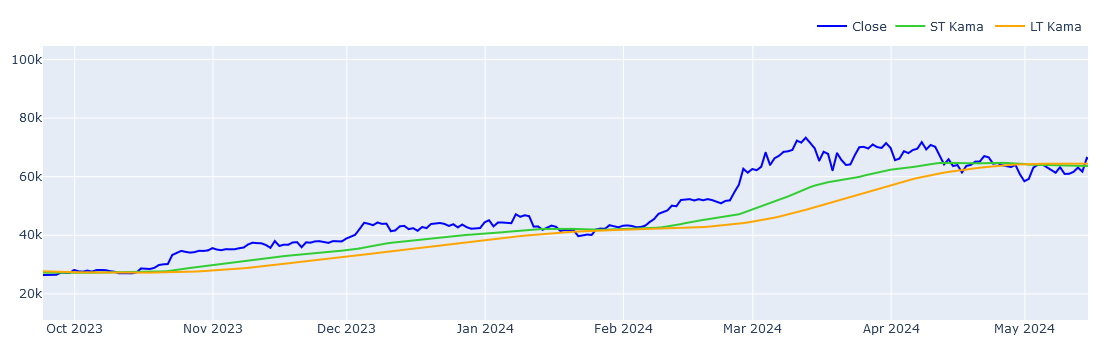

In [25]:
kama.plot(column='BTCUSD',
          close_kwargs=dict(trace_kwargs=dict(line_color='blue')),
          kama_st_kwargs=dict(trace_kwargs=dict(line_color='limegreen')),
          kama_lt_kwargs=dict(trace_kwargs=dict(line_color='orange'))).show()

## Signal Generation

In [87]:
@njit(nogil=True)
def generate_signals(kama_st_ma, kama_lt_ma):
    "Takes only one asset column, iterate in caller"
    entries = vbt.nb.crossed_above_1d_nb(kama_st_ma, kama_lt_ma)
    exits = vbt.nb.crossed_below_1d_nb(kama_st_ma, kama_lt_ma)
    
    return (entries,exits)

In [88]:
def get_signals_analysis(kama):
    long_entries = np.empty(close.shape, dtype=np.bool_)
    long_exits = np.empty(close.shape, dtype=np.bool_)
    
    for col in range(close.shape[1]):
        kama_st_ma = kama.kama_st_ma.values[:, col]
        kama_lt_ma = kama.kama_lt_ma.values[:, col]
        
        signals = generate_signals(kama_st_ma, kama_lt_ma)
        
        long_entries[:, col] = signals[0]
        long_exits[:, col] = signals[1]
    
    return (long_entries, long_exits)

In [89]:
signals = get_signals_analysis(kama)

## Pre-Analysis

In [90]:
def plot_signals(data, symbol, raw_signals, filtered_signals=None): 
    fig = data.plot(
        symbol=symbol, 
        ohlc_trace_kwargs=dict(opacity=0.5), 
        plot_volume=False
    )

    entries_raw = pd.DataFrame(raw_signals[0], columns=data.columns, index=data.index)
    exits_raw = pd.DataFrame(raw_signals[1], columns=data.columns, index=data.index)
    
    entries_raw[symbol].vbt.signals.plot_as_entries(y=data.get("Close", symbol), fig=fig)
    exits_raw[symbol].vbt.signals.plot_as_exits(y=data.get("Close", symbol), fig=fig)
    
    if(filtered_signals != None):
        entries_filtered = filtered_signals[0]
        exits_filtered = filtered_signals[1]
        
        entries_filtered[symbol].vbt.signals.plot_as_entry_marks(y=data.get("Close", symbol), fig=fig, trace_kwargs=dict(name="New entries"))
        exits_filtered[symbol].vbt.signals.plot_as_exit_marks(y=data.get("Close", symbol), fig=fig, trace_kwargs=dict(name="New exits"))

    fig.update_layout(height=600, width=1100)
    return fig

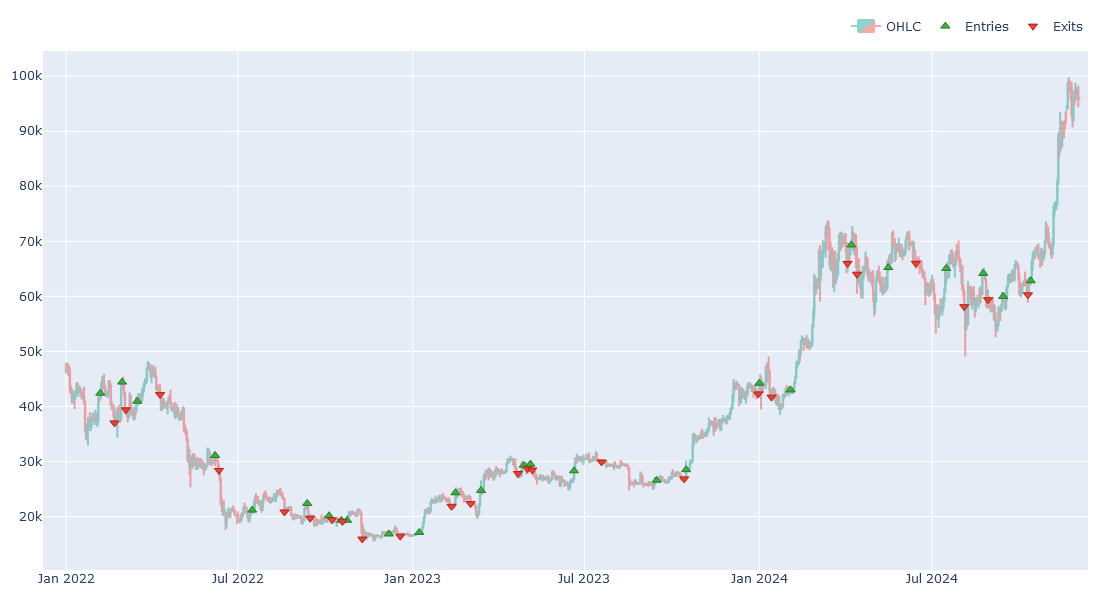

In [91]:
fig = plot_signals(data, 'BTCUSD', signals)
fig.show()

## Pipeline

In [16]:
kama_lt_ma_len=np.arange(15,35)
kama_st_ma_len=np.arange(5,15)
period = np.arange(2,35)

In [17]:
op_tree = (product, period, kama_st_ma_len, kama_lt_ma_len)
param_products = vbt.generate_param_combs(op_tree) 
period_prod = np.asarray(param_products[0])
kama_st_ma_len_prod = np.asarray(param_products[1])
kama_lt_ma_len_prod = np.asarray(param_products[2])

In [63]:
@njit(nogil=True)
def pipeline_nb(close, 
                kama_periods=np.asarray([11,12]), 
                kama_lt_ma_len=np.asarray([13,14]), 
                kama_st_ma_len=np.asarray([27,28]),
                ann_factor=365):

    num_metrics = 2
    metrics = np.empty((kama_periods.size * close.shape[1], num_metrics), dtype=np.float_)
    
    long_entries = np.empty(close.shape, dtype=np.bool_)
    long_exits = np.empty(close.shape, dtype=np.bool_)
    group_lens = np.full(close.shape[1], 1)
    k = 0

    for i in range(kama_periods.size):
        for col in range(close.shape[1]): # for each asset
 
            kama_st_ma, kama_lt_ma = get_kama_pairs(close[:, col], 
                                              kama_periods[i], 
                                              kama_st_ma_len[i], 
                                              kama_lt_ma_len[i])
            
            long_entries[:, col] = vbt.nb.crossed_above_1d_nb(kama_st_ma, kama_lt_ma, dropna=True)
            long_exits[:, col] = vbt.nb.crossed_below_1d_nb(kama_st_ma, kama_lt_ma, dropna=True)

        sim_out = vbt.pf_nb.from_signals_nb(
            target_shape=close.shape,
            group_lens=group_lens,
            close=close,
            long_entries=long_entries,
            long_exits=long_exits,
            save_returns=True
        )
        trades = long_exits.sum(axis=0)
        returns = sim_out.in_outputs.returns
        _sharpe = vbt.ret_nb.sharpe_ratio_nb(returns, ann_factor, ddof=1)

        metrics_vec = np.column_stack((trades, _sharpe))
        metrics_vec_len = len(metrics_vec)
        
        metrics[k:k + metrics_vec_len] = metrics_vec
        k += metrics_vec_len
            
    return metrics

In [64]:
ann_factor = vbt.pd_acc.returns.get_ann_factor(freq='1d')
pipeline_nb(close.values, ann_factor=ann_factor)

TypeError: got an unexpected keyword argument 'entries'

In [26]:
def merge_func(arrs, ann_args, input_columns):
    arr = np.concatenate(arrs)

    param_idx = vbt.stack_indexes((
        pd.Index(ann_args['kama_periods']['value'], name='kama_period'),
        pd.Index(ann_args['kama_st_ma_len']['value'], name='kama_st_ma'),
        pd.Index(ann_args['kama_lt_ma_len']['value'], name='kama_lt_ma')
    ))

    idx = vbt.combine_indexes((
        param_idx,
        input_columns
    ))
    
    return pd.DataFrame(arr, columns=['Total Trades', 'Sharpe'], index=idx)

In [27]:
nb_chunked = vbt.chunked(
    size=vbt.ArraySizer(arg_query='kama_periods', axis=0),
    arg_take_spec=dict(
        close=None,
        kama_periods=vbt.ArraySlicer(axis=0), 
        kama_lt_ma_len=vbt.ArraySlicer(axis=0), 
        kama_st_ma_len=vbt.ArraySlicer(axis=0),
        ann_factor=None
    ),
    merge_func=merge_func,
    merge_kwargs=dict(
        ann_args=vbt.Rep("ann_args")
    )
)

In [28]:
chunked_pipeline_nb = nb_chunked(pipeline_nb)

In [29]:
res = chunked_pipeline_nb(
    close.values,
    kama_periods=period_prod, 
    kama_st_ma_len=kama_st_ma_len_prod,
    kama_lt_ma_len=kama_lt_ma_len_prod,
    ann_factor=ann_factor,
    _execute_kwargs=dict(engine="dask"),
    _merge_kwargs=dict(input_columns=close.columns)
)

## Backtest Analysis

In [30]:
res.sort_values(by=['Total Trades'], ascending=False)

Total Trades    Sharpe
kama_period kama_st_ma kama_lt_ma symbol                        
2           12         15         BTCUSD          36.0  0.731578
            14         15         BTCUSD          36.0  0.460286
            10         15         SOLUSD          35.0  0.616950
            13         15         BTCUSD          35.0  0.532995
            14         15         SOLUSD          35.0  1.014359
...                                                ...       ...
26          14         32         ETHUSD           8.0  0.546910
                       31         ETHUSD           8.0  0.587489
                       30         ETHUSD           8.0  0.459548
                       29         ETHUSD           8.0  0.519611
            8          32         ETHUSD           8.0  0.477499

[19800 rows x 2 columns]

In [55]:
min_num_trades = 20
for ele in res.index.levels[-1]:
    df = res.loc[slice(None),slice(None),slice(None),ele]
    df = df[df['Total Trades'] > min_num_trades]
    df = df.sort_values(by=['Sharpe'], ascending=False)
    print(f"Parameter combination with highest Sharpe ratio for asset: {ele}") 
    print(df.head(1).index)
    print("\n")

Parameter combination with highest Sharpe ratio for asset: BTCUSD
MultiIndex([(7, 7, 15)],
           names=['kama_period', 'kama_st_ma', 'kama_lt_ma'])


Parameter combination with highest Sharpe ratio for asset: ETHUSD
MultiIndex([(4, 9, 15)],
           names=['kama_period', 'kama_st_ma', 'kama_lt_ma'])


Parameter combination with highest Sharpe ratio for asset: SOLUSD
MultiIndex([(6, 7, 18)],
           names=['kama_period', 'kama_st_ma', 'kama_lt_ma'])




In [59]:
kama = Kama.run(close,
                period=2, 
                kama_st_ma_len=12,
                kama_lt_ma_len=15)

In [60]:
signals = get_signals_analysis(kama)

In [61]:
pf = vbt.Portfolio.from_signals(
        close,
        entries=signals[0],
        exits=signals[1]
)

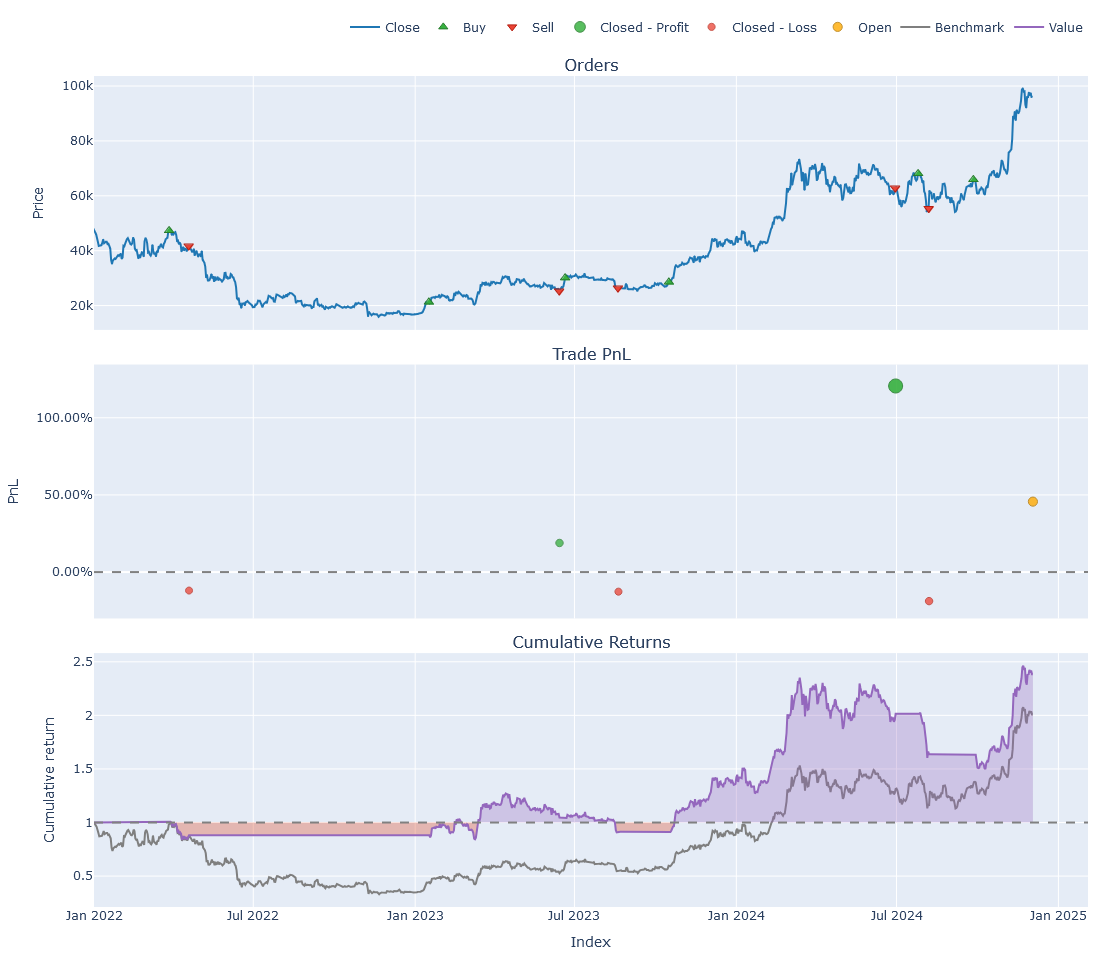

In [62]:
pf['BTCUSD'].plot().show()